# Computer Vision Project - Test Classifier on Rohit's Extracted Dataset
## Data Analysis Portion
### Warning - may take at least 10-15 minutes to run this entire notebook

In [1]:
import pandas as pd

comb_features_partial = pd.read_csv("./Rohit-s_part_preprocessing/rohit_combined_features2.csv")
train_test_split_assign_df = pd.read_csv("./Rohit-s_part_preprocessing/combined_split_updated.csv")
# Sanity check to make sure correct datasets are loaded
print(f"{comb_features_partial.head()}\n\n{train_test_split_assign_df.head()}")

               filename     mean_H      std_H      mean_S       std_S  \
0  soybean_rust_169.JPG  23.691391  25.280072  126.255127   92.312281   
1  soybean_rust_181.JPG  21.023529  27.519969  117.112411  101.064803   
2   soybean_rust_92.JPG  28.235947  26.223473  143.879974   90.294455   
3   soybean_rust_94.JPG  27.021790  26.320485  144.817108   93.302470   
4   soybean_rust_57.JPG  23.821274  27.994615  111.600479   98.952700   

          class  lesion_count  mean_lesion_area  mean_eccentricity  \
0  soybean_rust            26       1007.500000           0.812675   
1  soybean_rust            22       1534.045455           0.841685   
2  soybean_rust            23       1003.760870           0.843886   
3  soybean_rust            19       1307.894737           0.850669   
4  soybean_rust             1      65018.500000           0.661109   

   mean_circularity  infected_area_pct  
0          0.448213          41.200063  
1          0.319652          53.045282  
2          0.3480

In [2]:
# Train test split based upon previously generated CSV

SPLIT_COLUMN_LABEL = "split"
CLASS_COLUMN_LABEL = "class"
FILENAME_COLUMN_LABEL = "filename"
TRAIN_TAG = "train"
TEST_TAG = "test"

comb_features = pd.merge(comb_features_partial, train_test_split_assign_df, on=[FILENAME_COLUMN_LABEL])
# File extension processing came from ChatGPT generated code
comb_features[FILENAME_COLUMN_LABEL] = comb_features[FILENAME_COLUMN_LABEL].str.rsplit(".", n=1).str[0]
comb_features = comb_features.sort_values(by=FILENAME_COLUMN_LABEL, ascending=True).reset_index(drop=True)

indep_var_train_raw = (comb_features
                           .loc[comb_features[SPLIT_COLUMN_LABEL] == TRAIN_TAG, :]
                           .drop(columns=[FILENAME_COLUMN_LABEL, CLASS_COLUMN_LABEL, SPLIT_COLUMN_LABEL]))
indep_var_test_raw = (comb_features
                           .loc[comb_features[SPLIT_COLUMN_LABEL] == TEST_TAG, :]
                           .drop(columns=[FILENAME_COLUMN_LABEL, CLASS_COLUMN_LABEL, SPLIT_COLUMN_LABEL]))
dep_var_train = (comb_features
                     .loc[comb_features[SPLIT_COLUMN_LABEL] == TRAIN_TAG, CLASS_COLUMN_LABEL])
dep_var_test = (comb_features
                     .loc[comb_features[SPLIT_COLUMN_LABEL] == TEST_TAG, CLASS_COLUMN_LABEL])

# Z-scoring based on training data
indep_var_train_mean = indep_var_train_raw.mean()
indep_var_train_std = indep_var_train_raw.std()
indep_var_train = (indep_var_train_raw - indep_var_train_mean) / indep_var_train_std
indep_var_test = (indep_var_test_raw - indep_var_train_mean) / indep_var_train_std


Explained variability per principal component: [0.55384125 0.22820123 0.09792878]



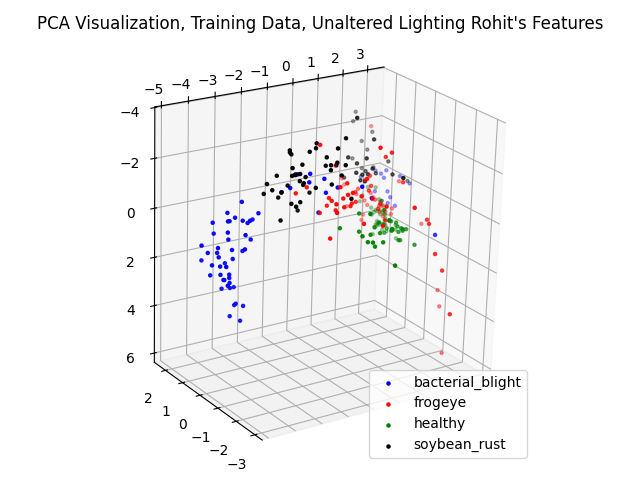

In [3]:
%matplotlib ipympl
# Manual PCA
import numpy as np
import matplotlib.pyplot as plt

plots_n_stats_dirname = "./plots_n_stats_dir/"
pca_plot_title = "PCA Visualization, Training Data, Unaltered Lighting Rohit's Features"

comb_features_indep_vars_scaled_np = indep_var_train.to_numpy(copy=True)
cov_comb_features_iv = np.cov(comb_features_indep_vars_scaled_np, rowvar=False)
eigvals_cov_comb_feats_iv, eigvecs_cov_comb_feats_iv = np.linalg.eig(cov_comb_features_iv)
rev_sorted_idxs = np.argsort(eigvals_cov_comb_feats_iv)[::-1]
eigvals_cov_comb_feats_iv_sorted = eigvals_cov_comb_feats_iv[rev_sorted_idxs]
eigvecs_cov_comb_feats_iv_sorted = eigvecs_cov_comb_feats_iv[:, rev_sorted_idxs]
decorrelated_comb_feats_iv = np.matmul(comb_features_indep_vars_scaled_np, eigvecs_cov_comb_feats_iv_sorted)
pca_3d_comb_feats_iv = decorrelated_comb_feats_iv[:, 0:3]
variance_ratios = eigvals_cov_comb_feats_iv_sorted / eigvals_cov_comb_feats_iv_sorted.sum()
pca_3d_comb_feats_iv_df = pd.DataFrame(pca_3d_comb_feats_iv,
                                       index=indep_var_train.index,
                                       columns=["PC1", "PC2", "PC3"])
pca_3d_comb_feats_iv_df.loc[:, "PC3"] *= -1 # Correction to make sure the plot looks the same as the reference

fig1 = plt.figure()
ax1 = fig1.add_subplot(projection="3d")
classes_list = comb_features.groupby(CLASS_COLUMN_LABEL).size().index.tolist()
colors_list = ["b", "r", "g", "k"]
print(f"\nExplained variability per principal component: {variance_ratios[0:3]}\n")
for class_name, color_str in zip(classes_list, colors_list):
    idxMask = dep_var_train == class_name
    ax1.scatter(pca_3d_comb_feats_iv_df.loc[idxMask, "PC1"],
                pca_3d_comb_feats_iv_df.loc[idxMask, "PC2"],
                pca_3d_comb_feats_iv_df.loc[idxMask, "PC3"],
                                 c=f"{color_str}", marker=".",
                                              label=class_name)
ax1.legend(loc="lower right")
ax1.set_title(pca_plot_title)
ax1.view_init(elev=-50, azim=-145, roll=60)
fig1.tight_layout()
fig1.savefig(plots_n_stats_dirname + "custom_pca_visualization_lighting_unalt_training_data_rohit.png")
plt.show();


Explained variability per principal component: [0.55384125 0.22820123 0.09792878]



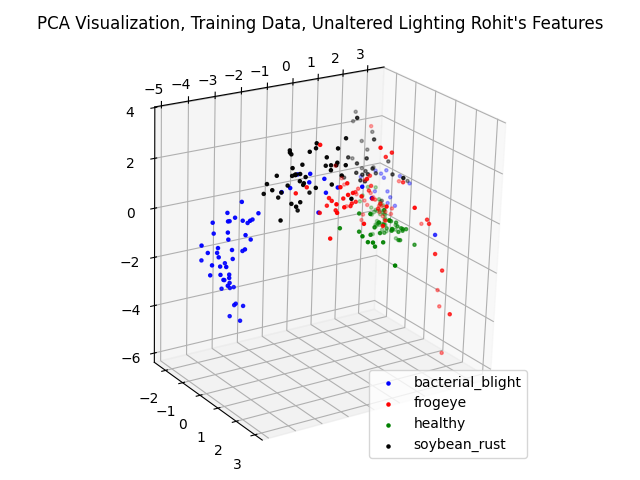

In [4]:
%matplotlib ipympl
# sklearn PCA; from https://www.datacamp.com/tutorial/principal-component-analysis-in-python
from sklearn.decomposition import PCA
iv_mat_normed = indep_var_train.values
pca_soybean = PCA(n_components=3)
principalComps_soybean = pca_soybean.fit_transform(iv_mat_normed)
principal_soybean_df = pd.DataFrame(principalComps_soybean,
                                    index=indep_var_train.index,
                                    columns=["PC1", "PC2", "PC3"])
print(f"\nExplained variability per principal component: {pca_soybean.explained_variance_ratio_}\n")

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection="3d")
for class_name, color_str in zip(classes_list, colors_list):
    idxMask = dep_var_train == class_name
    ax2.scatter(principal_soybean_df.loc[idxMask, "PC1"],
                principal_soybean_df.loc[idxMask, "PC2"],
                principal_soybean_df.loc[idxMask, "PC3"],
                                 c=f"{color_str}", marker=".",
                                              label=class_name)
ax2.legend(loc="lower right")
ax2.set_title(pca_plot_title)
ax2.view_init(elev=50, azim=145, roll=-120)
fig2.tight_layout()
plt.show();

In [5]:
# Mahalanobis Distance based classifier

def mahalanobis_dist(test_vec, mean_class_vec, cov_class_mat):
    mean_subbed_vec = test_vec - mean_class_vec
    dist_as_vec = np.expand_dims(mean_subbed_vec, axis=1).transpose() @ \
                       np.linalg.inv(cov_class_mat) @ np.expand_dims(mean_subbed_vec, axis=1)
    return dist_as_vec.squeeze().item()

# Building model
model_mean_vecs_n_covs = {}
mean_vec_key = "mean_vec"
cov_mat_key = "cov_mat"
for class_str in classes_list:
    model_dict = {}
    idxMask = dep_var_train == class_str
    training_data_per_class = indep_var_train.loc[idxMask].values
    model_dict.update({mean_vec_key: np.mean(training_data_per_class, axis=0)})
    model_dict.update({cov_mat_key: np.cov(training_data_per_class, rowvar=False)})
    model_mean_vecs_n_covs.update({class_str: model_dict})

# Labeling test data
labels = []
indices = []
for test_data_idx, test_data_row in indep_var_test.iterrows():
    dists_list = []
    for class_str in model_mean_vecs_n_covs:
        dists_list.append(mahalanobis_dist(test_data_row.values,
                                           model_mean_vecs_n_covs[class_str][mean_vec_key],
                                           model_mean_vecs_n_covs[class_str][cov_mat_key]))
    dists_arr = np.array(dists_list)
    labels.append(classes_list[np.argmin(dists_arr).item()])
    indices.append(test_data_idx)

# Final series for analysis
dep_var_computed = pd.Series(data=labels, index=indices)

                  precision    recall  f1-score   support

bacterial_blight       0.93      0.83      0.88        30
         frogeye       0.51      0.83      0.63        30
         healthy       1.00      0.57      0.72        30
    soybean_rust       0.81      0.73      0.77        30

        accuracy                           0.74       120
       macro avg       0.81      0.74      0.75       120
    weighted avg       0.81      0.74      0.75       120



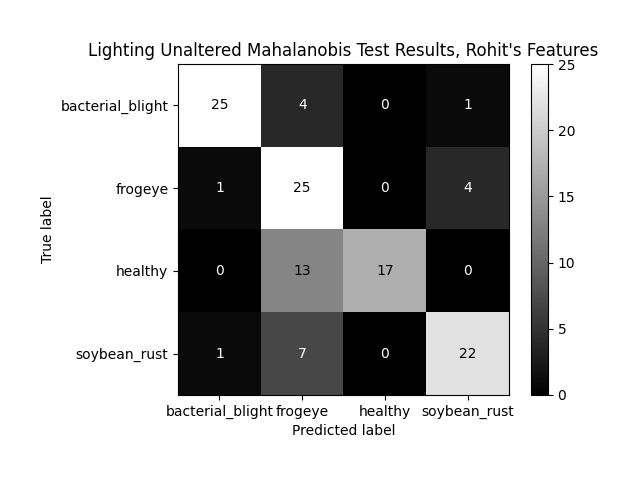

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_results_output_dir = "./model_comparisons/"
reference_test_data_ohe_csv_filename = "reference_test_data_ohe_light_unaltd_rohit.csv"
manhalanobis_test_data_ohe_csv_filename = "manhalanobis_test_data_ohe_light_unaltd_rohit.csv"
manhalanobis_clsf_rep_text_file = "manhalanobis_clsf_rep_light_unaltd_rohit.txt"
mhl_conf_mat_filename_no_ext = "manhalanobis_dist_conf_mat_light_unaltd_rohit"
mhl_results_title = "Lighting Unaltered Mahalanobis Test Results, Rohit's Features"

# Model Evaluations
one_hot_encoded_test_data_dv_df = \
        pd.DataFrame(data=(OneHotEncoder(categories=[classes_list],
                                                sparse_output=False)
                                                  .fit_transform(dep_var_test
                                                                   .values.reshape(-1, 1))),
                       index=dep_var_test.index, columns=classes_list)
one_hot_encoded_pred_data_dv_df = \
        pd.DataFrame(data=(OneHotEncoder(categories=[classes_list],
                                                sparse_output=False)
                                                  .fit_transform(dep_var_computed
                                                                   .values.reshape(-1, 1))),
                       index=dep_var_computed.index, columns=classes_list)
conf_mat_mahalanobis = confusion_matrix(dep_var_test, dep_var_computed)
conf_mat_mahbs_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_mahalanobis,
                                             display_labels=classes_list)
manhalanobis_clsf_rep = classification_report(dep_var_test, dep_var_computed, target_names=classes_list)
print(manhalanobis_clsf_rep)
conf_mat_mahbs_disp_plot = conf_mat_mahbs_disp.plot(cmap="gray")
conf_mat_mahbs_disp_plot.ax_.set_title(mhl_results_title)
conf_mat_mahbs_disp_plot.figure_.tight_layout(pad=3.0)
conf_mat_mahbs_disp_plot.figure_.savefig(plots_n_stats_dirname + \
                                         mhl_conf_mat_filename_no_ext + \
                                                                    ".png")
with open(plots_n_stats_dirname + manhalanobis_clsf_rep_text_file, "w", encoding="utf-8") as file:
    file.write(mhl_results_title + "\n\n" + manhalanobis_clsf_rep)
one_hot_encoded_test_data_dv_df.to_csv(test_results_output_dir + \
                                       reference_test_data_ohe_csv_filename, index=False)
one_hot_encoded_pred_data_dv_df.to_csv(test_results_output_dir + \
                                       manhalanobis_test_data_ohe_csv_filename, index=False)
plt.show();

In [7]:
# Scikit-learn RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

rfc_rand_seed = 43383
cv_fold_count = 8
accuracy_score_str = "accuracy"
num_estimators_list = [estim_count for estim_count in range(30, 151)]
min_samples_split_list = [split_count for split_count in range(2, 11)]
quality_split_function_list = ["gini", "entropy", "log_loss"]
max_features_params_list = ["sqrt", "log2", None]
n_estimators_param_str = "n_estimators"
criterion_param_str = "criterion"
min_samples_split_param_str = "min_samples_split"
max_features_param_str = "max_features"
random_state_param_str = "random_state"
all_params_for_search = {n_estimators_param_str: num_estimators_list,
                         criterion_param_str: quality_split_function_list,
                         min_samples_split_param_str: min_samples_split_list,
                         max_features_param_str: max_features_params_list,
                         random_state_param_str: [rfc_rand_seed]}

rf_classifier = RandomForestClassifier(random_state=rfc_rand_seed)
rf_classifier_scores = cross_val_score(rf_classifier, indep_var_train, dep_var_train,
                                           scoring=accuracy_score_str, cv=cv_fold_count)
rf_classifier_wrapped_by_gridsearch = GridSearchCV(rf_classifier, all_params_for_search,
                                                       scoring=accuracy_score_str, cv=cv_fold_count,
                                                       n_jobs=-1, verbose=1)
rf_classifier_wrapped_by_gridsearch.fit(indep_var_train, dep_var_train)
best_params_found_dict = rf_classifier_wrapped_by_gridsearch.best_params_
rf_classifier_best_params = RandomForestClassifier(n_estimators=best_params_found_dict[n_estimators_param_str],
                                                   criterion=best_params_found_dict[criterion_param_str],
                                                   min_samples_split=best_params_found_dict[min_samples_split_param_str],
                                                   max_features=best_params_found_dict[max_features_param_str],
                                                   random_state=rfc_rand_seed)
rf_classifier_scores_best_params = cross_val_score(rf_classifier_best_params, indep_var_train, dep_var_train,
                                                                  scoring=accuracy_score_str, cv=cv_fold_count)
print(f"\nAverage accuracy score for {cv_fold_count}-fold " + \
               f"cross validation: {rf_classifier_scores.mean()}")
print(f"\nAverage accuracy score for {cv_fold_count}-fold cross " + \
               f"validation after hyperparameter tuning: {rf_classifier_scores_best_params.mean()}")

Fitting 8 folds for each of 9801 candidates, totalling 78408 fits

Average accuracy score for 8-fold cross validation: 0.7857142857142857

Average accuracy score for 8-fold cross validation after hyperparameter tuning: 0.8071428571428572


                  precision    recall  f1-score   support

bacterial_blight       0.86      0.83      0.85        30
         frogeye       0.68      0.70      0.69        30
         healthy       0.86      0.80      0.83        30
    soybean_rust       0.81      0.87      0.84        30

        accuracy                           0.80       120
       macro avg       0.80      0.80      0.80       120
    weighted avg       0.80      0.80      0.80       120



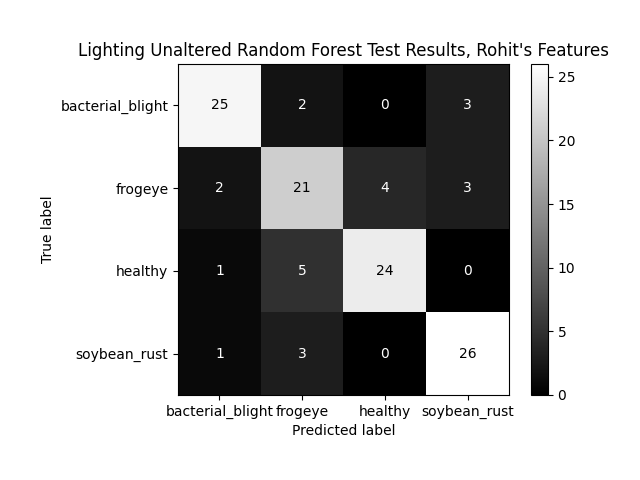

In [8]:
rfc_test_data_ohe_csv_filename = "rfc_test_data_ohe_light_unaltd_rohit.csv"
rfc_clsf_rep_text_file = "rfc_clsf_rep_light_unaltd_rohit.txt"
rfc_conf_mat_filename_no_ext = "rfc_dist_conf_mat_light_unaltd_rohit"
rfc_results_title = "Lighting Unaltered Random Forest Test Results, Rohit's Features"

# Random Forest model evaluation
rf_classifier_best_params.fit(indep_var_train, dep_var_train)
dep_var_computed_rfc = rf_classifier_best_params.predict(indep_var_test)
dep_var_test_vals = dep_var_test.values
one_hot_encoded_test_data_dv_rfc_df = \
        pd.DataFrame(data=(OneHotEncoder(categories=[classes_list],
                                                sparse_output=False)
                                                  .fit_transform(dep_var_test_vals
                                                                    .reshape(-1, 1))),
                       columns=classes_list)
one_hot_encoded_pred_data_dv_rfc_df = \
        pd.DataFrame(data=(OneHotEncoder(categories=[classes_list],
                                                sparse_output=False)
                                                  .fit_transform(dep_var_computed_rfc
                                                                       .reshape(-1, 1))),
                       columns=classes_list)
conf_mat_rfc = confusion_matrix(dep_var_test_vals, dep_var_computed_rfc)
conf_mat_rfc_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rfc,
                                             display_labels=classes_list)
rfc_clsf_rep = classification_report(dep_var_test_vals, dep_var_computed_rfc, target_names=classes_list)
print(rfc_clsf_rep)
conf_mat_rfc_disp_plot = conf_mat_rfc_disp.plot(cmap="gray")
conf_mat_rfc_disp_plot.ax_.set_title(rfc_results_title)
conf_mat_rfc_disp_plot.figure_.tight_layout(pad=3.0)
conf_mat_rfc_disp_plot.figure_.savefig(plots_n_stats_dirname + \
                                         rfc_conf_mat_filename_no_ext + \
                                                                    ".png")
with open(plots_n_stats_dirname + rfc_clsf_rep_text_file, "w", encoding="utf-8") as file:
    file.write(rfc_results_title + "\n\n" + rfc_clsf_rep)
one_hot_encoded_pred_data_dv_rfc_df.to_csv(test_results_output_dir + \
                                           rfc_test_data_ohe_csv_filename, index=False)
plt.show();